In [1]:
from lib.puzzles_generator_MET import prepare_data_p, prepare_data_v
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_p = prepare_data_p('/home/david/Bases/met/', puzzle_size=208, fragment_per_side=3, fragment_size=64, space=8, batch_size=1, data_aug=False, phase='val')

2


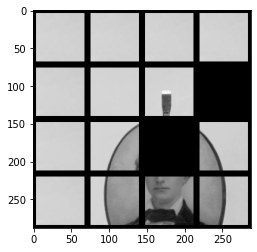

In [3]:
img, label, mask = data_p[0]
img = img.transpose(1,2,0).squeeze()
img = (img - np.min(img))/np.ptp(img)
print(label)
plt.imshow(img)

In [4]:
mask

array([[[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 1.]]])

In [5]:
data_v = prepare_data_v('/home/david/Bases/met/', puzzle_size=208, fragment_per_side=3, fragment_size=56, space=8, batch_size=1, phase='val', nb_helpers=5, data_aug=False)

[0]


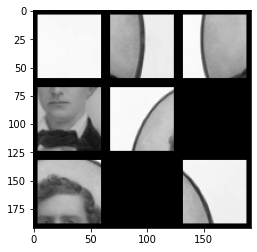

In [6]:
x, label, mask = data_v[0]
img = x.transpose(1,2,0).squeeze()
img = (img - np.min(img))/np.ptp(img)
print(label)
plt.imshow(img)

In [7]:
mask

array([[[1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.]]])

In [8]:
import observable_state, reassembly, game

In [9]:
args = {
    'dir_global': '/home/david/Bases/met/', 
    'puzzle_size': 192, 
    'fragment_per_side': 3, 
    'fragment_size': 56, 
    'space_size': 8,
    'fragments_nb': 9
}
g = game.Game(args['puzzle_size'], args['fragment_size'], args['fragments_nb'], space=args['space_size'])
fragments, solution_dicts = reassembly.prepare_problem(args, g, 0, phase="val", middle=False)

In [10]:
solution_dicts[5]['position'] = -1

In [11]:
nn_puzzle = g.vnet_input(solution_dicts, fragments, verbose=True)

[2, 8, 7, 0, 4, 3, 1, 6, -1]


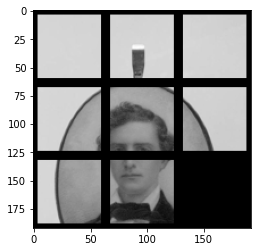

In [12]:
puz = nn_puzzle.squeeze().cpu().numpy().transpose(1,2,0)
puz = (puz - np.min(puz))/np.ptp(puz)
plt.imshow(puz)

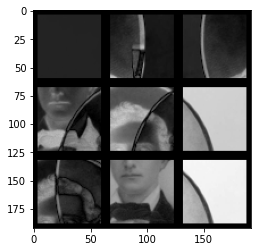

In [13]:
plt.imshow(np.abs(img - puz))

In [14]:
img.shape

(192, 192, 3)

In [15]:
puz.shape

(192, 192, 3)

In [16]:
np.sum(np.abs(img[0:4,...] - puz[0:4, ...]))

0.0

In [17]:
args['conv_head'] = True
global VERBOSE
VERBOSE = False
args['p_weight_path']= None #'tb_logs/model_p_64-8-64-8-64_h0/version_4/checkpoints/epoch=41.ckpt'
#args['v_weight_path']='tb_logs/model_v_64-8-64-8-64_h8/version_0/checkpoints/model_v-epoch=030-val_loss=0.026.ckpt'
args['v_weight_path']='tb_logs/model_v_56-8-56-8-56_h0/version_3/checkpoints/model_v-epoch=032-val_loss=0.497.ckpt'
p_net, v_net = reassembly.prepare_nnets(args)


256 64 8
rdim: 512
rdim: 512
v weights loaded from tb_logs/model_v_56-8-56-8-56_h0/version_3/checkpoints/model_v-epoch=032-val_loss=0.497.ckpt


In [18]:
import torch
from lib.utils import sigmoid

In [19]:
v_net(torch.tensor([x]).cuda())[0].detach().cpu().numpy()

array([0.07], dtype=float32)

In [20]:
v_net(nn_puzzle)[0].detach().cpu().numpy()

array([0.96], dtype=float32)

In [21]:
bs = 32
x = []
y = []
m = []
for i in range(bs):
    u, v, w = data_v[i]
    x.append(u)
    y.append(v)
    m.append(w)
y = torch.tensor(np.array(y).squeeze()).cuda()

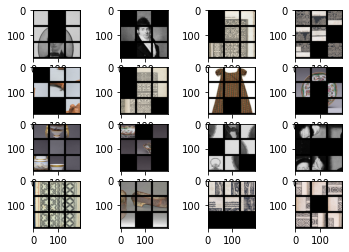

In [22]:
for i in range(min(bs, 16)):
    plt.subplot(4, 4, 1+i)
    plt.imshow(x[i].squeeze().transpose(1,2,0))

In [23]:
y

tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [24]:
y_ = v_net(torch.tensor(x).cuda(), torch.tensor(m).cuda()).squeeze()

In [25]:
y_

tensor([0.9507, 0.3867, 0.9360, 0.0145, 0.0310, 0.7114, 0.9206, 0.9257, 0.4093,
        0.2697, 0.0232, 0.5789, 0.5806, 0.9391, 0.1313, 0.2573, 0.5540, 0.2287,
        0.5816, 0.9651, 0.0279, 0.9878, 0.5244, 0.0815, 0.6306, 0.4373, 0.0380,
        0.2640, 0.4035, 0.1919, 0.0932, 0.3364], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [26]:
(y_>0.5).int()

tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [27]:
((y_>0.5).float() == y).sum()/bs

tensor(0.8125, device='cuda:0')

In [28]:
((y_>0.5).float() == y)

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True, False,
         True, False], device='cuda:0')